In [19]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import panel as pn 
import networkx as nx
import seaborn as sns
import csv
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from bokeh.io import output_notebook, export_png
from bokeh.plotting import figure,show 
from bokeh.layouts import column, row, grid
from sklearn.decomposition import PCA
output_notebook()
pn.extension()

Loading BokehJS ...

In [2]:
def get_config():
    with open("config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

In [3]:
def combine_datasets(ccre, euclidean):
    config = get_config()

    ccre_df = pd.read_csv(config[ccre])
    euclidean_df = pd.read_csv(config[euclidean])
    x = np.array(ccre_df['ccre(X|Y)'][:])
    y = np.array(euclidean_df['euclidean_similarity'][:])
    
    #combine
    df = pd.concat([euclidean_df, ccre_df], axis=1)
    df = df.loc[:,~df.columns.duplicated()].copy()
    hospitals = df['hospital'].str.split('_') 

    same_centre_bools = [] 
    for hospital in hospitals:
        if hospital[0] == hospital[1]:
            same_centre_bools.append(True)
        else:
            same_centre_bools.append(False)
    df['same_centre'] = same_centre_bools
    return df

In [4]:
df = combine_datasets(ccre="ccre_all", euclidean="euclidean_all")
df.loc[df['ccre(X|Y)'].str[0] == '[', "ccre(X|Y)"] = 0
df = df.astype({'ccre(X|Y)':'float'})
df = df.astype({'euclidean_similarity':'float'})
patients_to_remove = [23, 25, 27,30,32,34,35,36,40,52, 56, 104,110,111,117,120,134,140,148,159,161,162, 171,179,180,181,182,191,192,196,205,211,215,216, 230,233,236,237,238,239,242,243,245, 247,252,253,254,256,258,262,272,275,277,279,284,285,286,287,289,290,291,292,294,295,296,297,298,299,300,301,303]
df = df[(~df['id_x'].isin(patients_to_remove)) & ~df['id_y'].isin(patients_to_remove)]

In [5]:
df.fillna({'ccre(X|Y)': 1}, inplace=True)
df

,id_x,id_y,hospital,diagnosis,euclidean_distance,euclidean_similarity,cre(x),cre(y),E[cre(X|Y)],ccre(X|Y),same_centre
0,0,1,UMCG_UMCG,HC_HC,16.561167,0.056944,1.423117,1.280979,-1.354576,0.048162,True
1,19,0,UMCG_UMCG,PD_HC,17.831924,0.053101,2.186887,1.423117,-1.688956,0.227689,True
2,57,0,UMCG_UMCG,AD_HC,47.326398,0.020693,5.113884,1.423117,-4.217813,0.175223,True
3,38,0,UMCG_UMCG,PD_HC,39.546871,0.024663,3.877309,1.423117,-3.845329,0.008248,True
4,0,2,UMCG_UMCG,HC_HC,16.325006,0.057720,1.423117,1.274866,-1.283575,0.098054,True
...,...,...,...,...,...,...,...,...,...,...,...
91787,302,281,CUN_CUN,PD_PD,31.315242,0.030945,4.163102,2.812678,-2.939135,0.294004,True
91788,302,282,CUN_CUN,PD_PD,32.643134,0.029724,4.163102,2.832751,-3.036574,0.270598,True
91789,302,283,CUN_CUN,PD_PD,33.226441,0.029217,4.163102,1.770693,-2.940674,0.293634,True
91794,302,288,CUN_CUN,PD_PD,36.532513,0.026644,4.163102,2.939166,-3.446644,0.172097,True


In [6]:
def compare_scatter_plots(disease1="HC", disease2="HC"):
    
    combine_diseases = f"{disease1}_{disease2}"
    figures = []
    for i in sources_names:

        for j in sources_names:

            combine_centres = f"{i}_{j}"
            dataset = df[(df.hospital == combine_centres) & (df.diagnosis == combine_diseases)]
         

            figure1 = figure(height=400, width=400, title=f"{combine_centres} {combine_diseases}")
            figure1.scatter('ccre(X|Y)', 'euclidean_similarity', source=dataset)
            figure1.xaxis.axis_label = "ccre"
            figure1.yaxis.axis_label = "euclidean similarity"
            figures.append(figure1)
    
    return grid([
        [figures[0], figures[1], figures[2]],
        [figures[3], figures[4], figures[5]],
        [figures[6], figures[7], figures[8]]
    ])
            

sources_names = ["UMCG", "UGOSM", "CUN"]
diagnosis = ["HC", "AD", "PD"]
scatter_plots = pn.interact(compare_scatter_plots, disease1=diagnosis, disease2=diagnosis)
scatter_plots

BokehModel(combine_events=True, render_bundle={'docs_json': {'7fab0ccc-540d-4793-a303-5d4943286dc7': {'version…

In [7]:
def cumulative_histogram(diagnosis1 = "PD", diagnosis2 = "PD"):
    
    combine_diseases = f"{diagnosis1}_{diagnosis2}"
    figures = []
    for i in sources_names:

        for j in sources_names:

            combine_centres = f"{i}_{j}"
            data = df[(df.hospital == combine_centres) & (df.diagnosis == combine_diseases)]
            
            ecdf = ECDF(data['ccre(X|Y)'])
            ecdf2 = ECDF(data['euclidean_similarity'])
           
            plot1 = figure(width=400, height=400, title=f"{combine_centres} {combine_diseases}")
            plot1.line(ecdf.x, ecdf.y)
            plot1.line(ecdf2.x, ecdf2.y, color='orange')
          
            figures.append(plot1)
    

    return grid([
        [figures[0], figures[1], figures[2]],
        [figures[3], figures[4], figures[5]],
        [figures[6], figures[7], figures[8]]
    ])
cumulative_plots = pn.interact(cumulative_histogram, diagnosis1=diagnosis, diagnosis2=diagnosis)
cumulative_plots


BokehModel(combine_events=True, render_bundle={'docs_json': {'c49fbe98-2bf2-4da4-8fa2-bc88a27376fb': {'version…

In [8]:
sorted_df = df.sort_values(['hospital', 'diagnosis'])


In [9]:
list_of_id = sorted_df['id_x'].unique()

def adjacency_matrix(metric):
    squared_matrix = []
    temp_values = []
    for i in list_of_id:
 
        

        for j in list_of_id:
            if i == j:
                temp_values.append(1)
            else:

                temp_values.append(sorted_df[(sorted_df['id_x'] == i) & (sorted_df['id_y'] == j)][metric].values[0])
        if len(temp_values) == len(list_of_id):
            
            squared_matrix.append(temp_values)
            temp_values = []
    return squared_matrix
CCRE_matrix = adjacency_matrix('ccre(X|Y)')
euclidean_matrix = adjacency_matrix('euclidean_similarity')


In [10]:
df

,id_x,id_y,hospital,diagnosis,euclidean_distance,euclidean_similarity,cre(x),cre(y),E[cre(X|Y)],ccre(X|Y),same_centre
0,0,1,UMCG_UMCG,HC_HC,16.561167,0.056944,1.423117,1.280979,-1.354576,0.048162,True
1,19,0,UMCG_UMCG,PD_HC,17.831924,0.053101,2.186887,1.423117,-1.688956,0.227689,True
2,57,0,UMCG_UMCG,AD_HC,47.326398,0.020693,5.113884,1.423117,-4.217813,0.175223,True
3,38,0,UMCG_UMCG,PD_HC,39.546871,0.024663,3.877309,1.423117,-3.845329,0.008248,True
4,0,2,UMCG_UMCG,HC_HC,16.325006,0.057720,1.423117,1.274866,-1.283575,0.098054,True
...,...,...,...,...,...,...,...,...,...,...,...
91787,302,281,CUN_CUN,PD_PD,31.315242,0.030945,4.163102,2.812678,-2.939135,0.294004,True
91788,302,282,CUN_CUN,PD_PD,32.643134,0.029724,4.163102,2.832751,-3.036574,0.270598,True
91789,302,283,CUN_CUN,PD_PD,33.226441,0.029217,4.163102,1.770693,-2.940674,0.293634,True
91794,302,288,CUN_CUN,PD_PD,36.532513,0.026644,4.163102,2.939166,-3.446644,0.172097,True


In [11]:
df[df['id_x'] == list_of_id[232]]['diagnosis'].values[0].split('_')[0]

'PD'

In [12]:
# print(list_of_id)
hospital_diagnosis_full = []

for i in list_of_id:
    
    hospital = df[df['id_x'] == i]['hospital'].values[0].split('_')[0]
    diagnosis = df[df['id_x'] == i]['diagnosis'].values[0].split('_')[0]
    hospital_diagnosis_full.append(f'{hospital}_{diagnosis}')


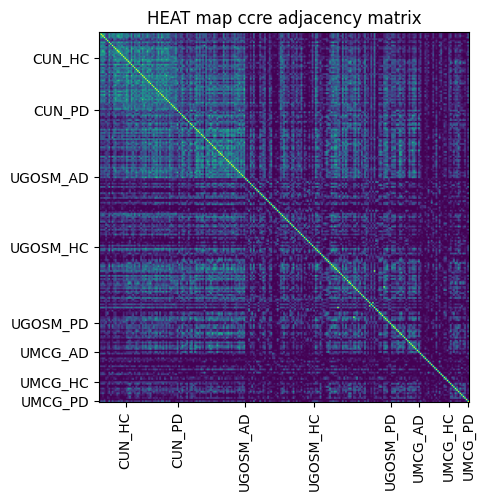

In [13]:
position = [16, 49, 91, 135, 183, 201, 220, 232]
hospital_diagnosis = ['CUN_HC', 'CUN_PD', 'UGOSM_AD', 'UGOSM_HC', 'UGOSM_PD', 'UMCG_AD', 'UMCG_HC', 'UMCG_PD']
plt.xticks(position, hospital_diagnosis, rotation='vertical')
plt.yticks(position, hospital_diagnosis)
plt.title('HEAT map ccre adjacency matrix')
plt.imshow(CCRE_matrix, vmin=0, vmax=1)


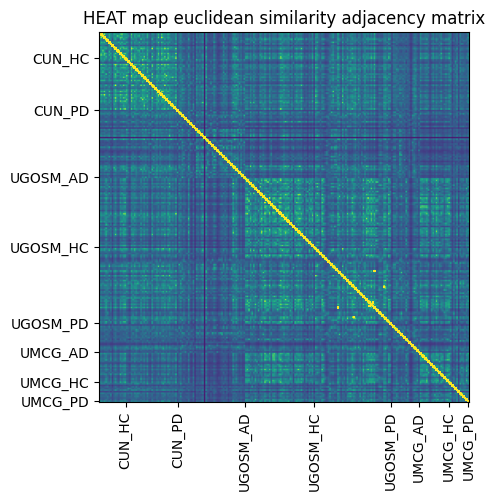

In [14]:

plt.xticks(position, hospital_diagnosis, rotation='vertical')
plt.yticks(position, hospital_diagnosis)
plt.title('HEAT map euclidean similarity adjacency matrix')
plt.imshow(euclidean_matrix, vmin=0, vmax=0.1)

PCA

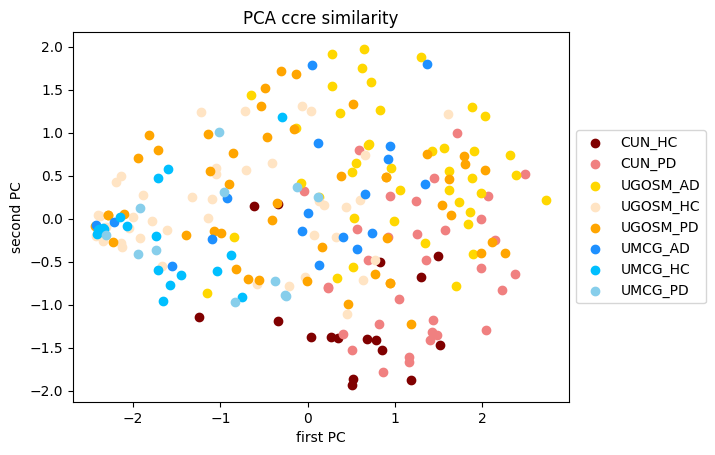

In [17]:
from collections import OrderedDict
X = np.array(CCRE_matrix)
pca = PCA(n_components=232)
pca_fit = pca.fit_transform(X)
data = {'pc1': pca_fit[:, 0], 'pc2':pca_fit[:, 1], 'labels': hospital_diagnosis_full}
test = pd.DataFrame(data).values
colors = {'CUN_HC': 'maroon', 'CUN_PD': 'lightcoral', 'UGOSM_AD': 'gold', 'UGOSM_PD': 'orange', 'UGOSM_HC': 'bisque', 'UMCG_HC': 'deepskyblue', 'UMCG_PD': 'skyblue', 'UMCG_AD': 'dodgerblue'}
for i in test:
    plt.scatter(i[0], i[1], color=colors[i[2]],label=i[2])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title('PCA ccre similarity')
plt.xlabel('first PC')
plt.ylabel('second PC')
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

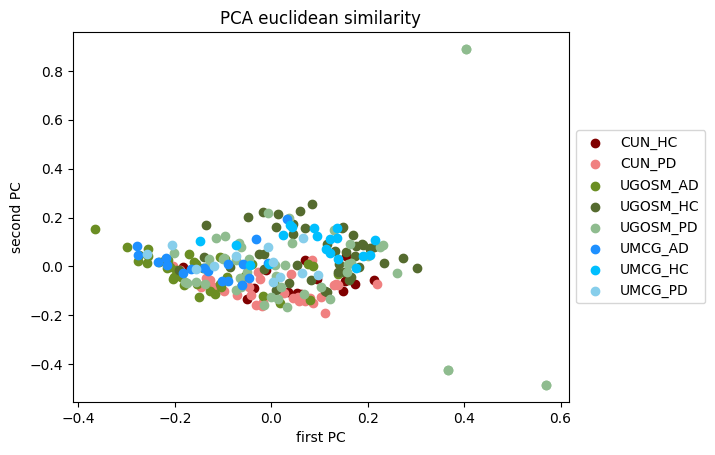

In [18]:
X = np.array(euclidean_matrix)
pca = PCA(n_components=232)
pca_fit = pca.fit_transform(X)
data = {'pc1': pca_fit[:, 0], 'pc2':pca_fit[:, 1], 'labels': hospital_diagnosis_full}
test = pd.DataFrame(data).values
colors = {'CUN_HC': 'maroon', 'CUN_PD': 'lightcoral', 'UGOSM_AD': 'olivedrab', 'UGOSM_PD': 'darkseagreen', 'UGOSM_HC': 'darkolivegreen', 'UMCG_HC': 'deepskyblue', 'UMCG_PD': 'skyblue', 'UMCG_AD': 'dodgerblue'}
for i in test:
    plt.scatter(i[0], i[1], color=colors[i[2]],label=i[2])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title('PCA euclidean similarity')
plt.xlabel('first PC')
plt.ylabel('second PC')
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

In [66]:
def compare_metrics(hospital, first_diagnosis, second_diagnosis):

    first = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{first_diagnosis}_{first_diagnosis}")]
    second = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{second_diagnosis}_{second_diagnosis}")]

    third = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{first_diagnosis}_{second_diagnosis}")]
    fourth = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{second_diagnosis}_{first_diagnosis}")]
    
    #euclidean distance
    euclidean_first = first['euclidean_distance'].median() / (pd.concat([third['euclidean_distance'], fourth['euclidean_distance']])).median()
    euclidean_second = second['euclidean_distance'].median() / (pd.concat([third['euclidean_distance'], fourth['euclidean_distance']])).median()
    
    #ccre
    ccre_first = first['ccre(X|Y)'].median() / (pd.concat([third['ccre(X|Y)'], fourth['ccre(X|Y)']])).median()
    ccre_second = second['ccre(X|Y)'].median() / (pd.concat([third['ccre(X|Y)'], fourth['ccre(X|Y)']])).median()
    
    header = ...
    data = ...
    
    if "compare.csv":
        with open(f"euclidean_distances.csv", "a", newline="") as file:
            writer = csv.writer(file)
        
            writer.writerow(header)
            writer.writerow(data)
    else:
        writer.writerow(data)
    print(f'formula 1 mean({first_diagnosis})/ mean(between {first_diagnosis} and {second_diagnosis}) , ccre average = {ccre_first}, euclidean distance average = {euclidean_first}, ccre < euclidean similarity {ccre_first<euclidean_first}')
    print(f'formula 2 mean({second_diagnosis})/ mean(between {first_diagnosis} and {second_diagnosis}) , ccre average = {ccre_second}, euclidean distance average = {euclidean_second}, ccre < euclidean similarity {ccre_second<euclidean_second}\n')


In [67]:
hospitals = ['UMCG_UMCG', 'UMCG_UGOSM', 'UMCG_CUN', 'UGOSM_UMCG', 'UGOSM_UGOSM',
       'UGOSM_CUN', 'CUN_UMCG', 'CUN_UGOSM', 'CUN_CUN']
for hospital in hospitals:
    print(hospital)
    compare_metrics(hospital, 'HC', 'PD')
    if "CUN" not in hospital:
       compare_metrics(hospital, 'HC', 'AD')
       compare_metrics(hospital, 'AD', 'PD')


UMCG_UMCG
formula 1 mean(HC)/ mean(HC and PD) , ccre average = 0.5010614062356729, euclidean distance average = 0.75209041575321, ccre < euclidean similarity True
formula 2 mean(PD)/ mean(HC and PD) , ccre average = 6.460792385088047, euclidean distance average = 0.9698808875678162, ccre < euclidean similarity False

formula 1 mean(HC)/ mean(HC and AD) , ccre average = 0.9981556836778468, euclidean distance average = 0.6087223697481956, ccre < euclidean similarity False
formula 2 mean(AD)/ mean(HC and AD) , ccre average = 25.493221315460474, euclidean distance average = 0.9275889250296613, ccre < euclidean similarity False

formula 1 mean(AD)/ mean(AD and PD) , ccre average = 1.6762929168103897, euclidean distance average = 1.0163307715095034, ccre < euclidean similarity False
formula 2 mean(PD)/ mean(AD and PD) , ccre average = 0.8462882481985503, euclidean distance average = 0.860096398114596, ccre < euclidean similarity True

UMCG_UGOSM
formula 1 mean(HC)/ mean(HC and PD) , ccre ave